
```
CNN for computer vision
```
Task: Build and train a convolutional neural network to classify images of clothing using the CIFAR 10 dataset.


Part 2 and 3: CIFAR 10 Datasets with Simple CNNs
Improved the model's accuracy by modifying the network architecture by adding dropout layers to prevent overfitting


Install and import dependencies


In [1]:
import tensorflow as tf
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


Extract and load the CIFAR dataset



In [2]:
import os
import glob

# Download the data
_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
zip_dir = tf.keras.utils.get_file('cifar-10-python.tar.gz', origin=_URL, extract=True)

# Get the data and meta file names
data_dir = os.path.join(os.path.dirname(zip_dir), 'cifar-10-batches-py')
train_files = glob.glob(os.path.join(data_dir,"data_batch_*"))
test_file = os.path.join(data_dir,"test_batch")
meta_file = os.path.join(data_dir,"batches.meta")

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def build_dataset(files):
    x = []
    y = []
    for file in files:
        dict = unpickle(file)
        for image in dict[b'data']:
            # Image in the dataset is stored as a 3072 length 1D array
            x.append(image)
        for label in dict[b'labels']:
            y.append(label)

    return tf.data.Dataset.from_tensor_slices((x,y))

# Build the training dataset
train_dataset  = build_dataset(train_files)

# Build the testing dataset
test_dataset = build_dataset([test_file])

# Get the metadata
meta = unpickle(meta_file)

170498071/170498071 [==============================] - 4s 0us/step


Preprocess the data: normalization and reshaping

In [5]:
def reshape_and_normalize(images, labels):
    # Convert from 1D array to 3D array of [3, 32, 32]
    # the image is stored as [colour channel, width, height]
    images = tf.reshape(images, (3, 32, 32))
    # Swap from [colour channel, width, height] to [width, height, colour channel]
    images = tf.transpose(images, (1, 2, 0))
    # Convert to float32
    images = tf.cast(images, tf.float32)
    # Normalize
    images /= 255
    return images, labels


train_dataset =  train_dataset.map(reshape_and_normalize)
test_dataset  =  test_dataset.map(reshape_and_normalize)

In [6]:
num_train_examples = 50000
BATCH_SIZE = 32
train_dataset = train_dataset.cache().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

Create and train model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               5

Compile the model

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', 'mse'])
history = model.fit(train_dataset,
          epochs=10,
          validation_data=test_dataset)

Epoch 1/10
1563/1563 [==============================] - 110s 65ms/step - loss: 2.3028 - accuracy: 0.0984 - mse: 28.5098 - val_loss: 2.3026 - val_accuracy: 0.1000 - val_mse: 28.5097
Epoch 2/10
 769/1563 [=============>................] - ETA: 44s - loss: 2.3028 - accuracy: 0.0982 - mse: 28.6574

KeyboardInterrupt: 

Evaluate the model

In [117]:
model.evaluate(test_dataset)

313/313 [==============================] - 1s 3ms/step - loss: 2.3026 - accuracy: 0.1000 - mse: 27.6100


[2.3026421070098877, 0.10000000149011612, 27.60997200012207]

313/313 - 1s - loss: 9.6818 - accuracy: 0.0997 - mse: 27.6907 - 998ms/epoch - 3ms/step


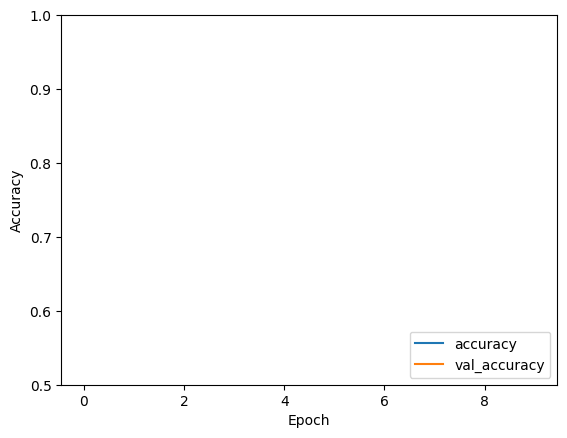

In [118]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

results = model.evaluate(x_test,  y_test, verbose=2)
test_loss, test_acc = results[0], results[1]

Accuracy:

In [97]:
print(test_acc)

0.47609999775886536


Generate a confusion matrix:

In [98]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test data
y_pred = model.predict(x_test)

# Convert the predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print(confusion_matrix)

313/313 [==============================] - 1s 2ms/step
[[857  20  15  25   4   2   5  17  34  21]
 [118 649   3  28   2   4   3  19  63 111]
 [299  36 200 195  19  96  25  69  40  21]
 [125  41  22 448  14 173  26  69  47  35]
 [188  28  48 315 118  88  36 121  34  24]
 [ 90  22  18 303  10 428  15  69  22  23]
 [103  76  57 231  23  79 314  35  52  30]
 [131  17   9 103  16  73   5 604  10  32]
 [320  34   1  28   3   6   4  18 553  33]
 [146 119   2  27   4   6   1  38  67 590]]


Save the model

In [99]:
model_name = 'cifar_cnn.h5'
model.save(model_name, save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
